# Test the performance of chronos model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from peft import PeftModel, PeftConfig
from IPython.display import clear_output
import time

/home/swc/trading/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("大盤K棒.csv")

In [3]:
config = PeftConfig.from_pretrained("output/run-0/checkpoint-final")

In [4]:
pipeline.model.model.load_adapter("output/run-0/checkpoint-final")

In [14]:
df = df[-120:]

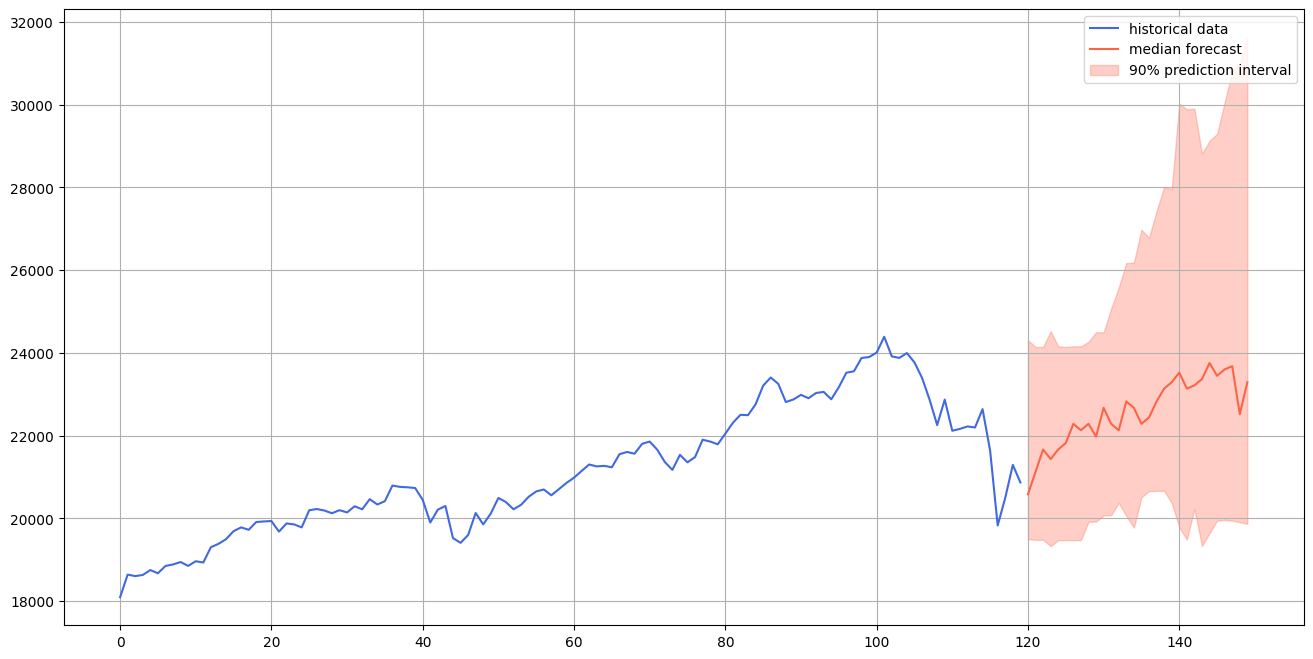

In [15]:
context = torch.tensor(df["收盤指數"].values)
prediction_length = 30
forecast = pipeline.predict(
    context, prediction_length
)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.05, 0.5, 0.95], axis=0)

plt.figure(figsize=(16, 8))
plt.plot(df["收盤指數"].values[:], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(
    forecast_index,
    low,
    high,
    color="tomato",
    alpha=0.3,
    label="90% prediction interval",
)
plt.legend()
plt.grid()
plt.show()

In [22]:
print(low[:5])
print(median[:5])
print(high[:5])

[19451.50537515 18815.59137289 20417.84720664 20193.40707192
 20074.95250287]
[20698.39760313 21134.80917331 21384.18721341 21446.53172344
 21446.53172344]
[21471.46952745 21839.30223797 21851.77113998 22331.82579326
 22587.43828437]


In [2]:
import json

f = open("./config/key.json")
keyData = json.load(f)["shioaji"]
api_key = keyData["api_key"]
secret_key = keyData["secret_key"]
f.close()

In [61]:
import shioaji as sj
import datetime
from decimal import Decimal



api = sj.Shioaji(simulation=True)  # 模擬模式
api.login(api_key=api_key, secret_key=secret_key)

Response Code: 0 | Event Code: 0 | Info: host '210.59.255.161:80', IP 210.59.255.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='H125544207', broker_id='F002000', account_id='1835212', username='蘇暐中'),
 Account(account_type=<AccountType.H: 'H'>, person_id='H125544207', broker_id='9A9X', account_id='00176282', username='蘇暐中'),
 StockAccount(person_id='H125544207', broker_id='9A9X', account_id='0538412', username='蘇暐中')]

In [67]:
prev_time = datetime.datetime(2024, 8, 7, 3, 27)
prices = np.array([])


@api.on_tick_fop_v1()
def quote_callback(exchange: sj.Exchange, tick: sj.TickFOPv1):
    # update every second
    cur_time = tick["datetime"].replace(second=0, microsecond=0)
    global prev_time
    global prices
    if cur_time > prev_time:
        prev_time = cur_time
        prices = np.append(prices, float(tick["close"]))
        print(f"Time: {str(cur_time)}  Price: {prices[-1]}", end="\r")


api.quote.subscribe(
    api.Contracts.Futures.TXF["TXFR1"],
    quote_type=sj.constant.QuoteType.Tick,
    version=sj.constant.QuoteVersion.v1,
)

Response Code: 200 | Event Code: 16 | Info: TIC/v1/FOP/*/TFE/TXFH4 | Event: Subscribe or Unsubscribe ok


In [16]:
prices.shape

(780,)

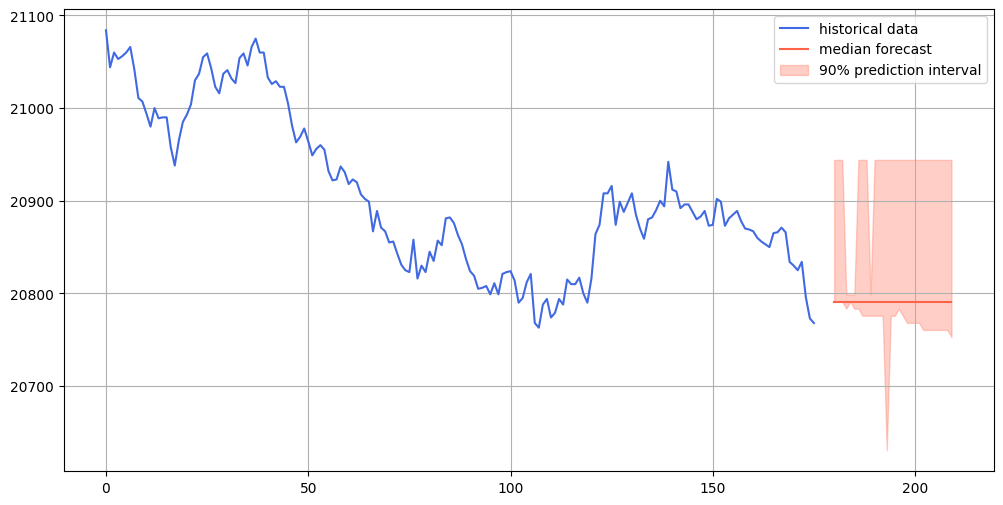

Low: [20791.20290997 20791.20290997 20791.20290997 20783.55909268
 20791.20290997 20783.55909268 20783.55909268 20775.91527539
 20775.91527539 20775.91527539]
Median: [20791.20290997 20791.20290997 20791.20290997 20791.20290997
 20791.20290997 20791.20290997 20791.20290997 20791.20290997
 20791.20290997 20791.20290997]
High: [20944.07925573 20944.07925573 20944.07925573 20798.84672726
 20798.84672726 20798.84672726 20944.07925573 20944.07925573
 20944.07925573 20798.84672726]


NameError: name 'time' is not defined

In [18]:
prices_len = 0
while True:

    global prices_len
    global prices
    if len(prices) > prices_len:
        prices_len = len(prices)
    else:
        time.sleep(10)
        continue

    context = torch.tensor(prices[-120:])
    prediction_length = 30
    forecast = pipeline.predict(
        context, prediction_length
    )  # shape [num_series, num_samples, prediction_length]

    # visualize the forecast
    prev_price_num = len(prices) if len(prices) < 180 else 180

    forecast_index = range(prev_price_num, prev_price_num + prediction_length)
    low, median, high = np.quantile(forecast[0].numpy(), [0.05, 0.5, 0.95], axis=0)
    low = low
    median = median
    high = high
    clear_output()
    plt.figure(figsize=(12, 6))
    plt.plot(prices[-prev_price_num:], color="royalblue", label="historical data")
    plt.plot(forecast_index, median, color="tomato", label="median forecast")
    plt.fill_between(
        forecast_index,
        low,
        high,
        color="tomato",
        alpha=0.3,
        label="90% prediction interval",
    )
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    print(f"Low: {low[:10]}")
    print(f"Median: {median[:10]}")
    print(f"High: {high[:10]}")

In [4]:
# get history data

first_date = "2024-07-31"
second_date = "2024-08-01"


def get_history_data(first_date="2024-07-31", second_date="2024-08-01"):
    history_prices = []
    for i in range(15, 24):
        for j in range(60):
            if i == 23 and j == 59:
                break
            history_prices
            time_start = f"{i}:{j}:00"
            time_end = f"{i+1}:00:00" if j == 59 else f"{i}:{j+1}:00"
            ticks = api.ticks(
                contract=api.Contracts.Futures.TXF["TXFR1"],
                date=first_date,
                query_type=sj.constant.TicksQueryType.RangeTime,
                time_start=time_start,
                time_end=time_end,
            )
            history_prices.append(np.mean(ticks["close"]))
            time.sleep(0.1)
            print(f"Get {time_start} data.", end="\r")
    ticks = api.ticks(
        contract=api.Contracts.Futures.TXF["TXFR1"],
        date=first_date,
        query_type=sj.constant.TicksQueryType.RangeTime,
        time_start="23:59:00",
        time_end="23:59:59",
    )
    history_prices.append(np.mean(ticks["close"]))
    print(f"Get 23:59:00 data.", end="\r")
    for i in range(0, 4):
        for j in range(60):
            history_prices
            time_start = f"{i}:{j}:00"
            time_end = f"{i+1}:00:00" if j == 59 else f"{i}:{j+1}:00"
            ticks = api.ticks(
                contract=api.Contracts.Futures.TXF["TXFR1"],
                date=second_date,
                query_type=sj.constant.TicksQueryType.RangeTime,
                time_start=time_start,
                time_end=time_end,
            )
            history_prices.append(np.mean(ticks["close"]))
            time.sleep(0.1)
            print(f"Get {time_start} data.", end="\r")
    file_name = "future_price.csv"
    df = pd.read_csv(file_name)
    df[first_date] = history_prices
    df.to_csv(file_name, index=False)
    print(f"Write {first_date} data.")

In [7]:
date_list = [
    ["2024-07-22", "2024-07-23", "2024-07-24"],
    [
        "2024-07-15",
        "2024-07-16",
        "2024-07-17",
        "2024-07-18",
        "2024-07-19",
        "2024-07-20",
    ],
    [
        "2024-07-08",
        "2024-07-09",
        "2024-07-10",
        "2024-07-11",
        "2024-07-12",
        "2024-07-13",
    ],
    [
        "2024-07-01",
        "2024-07-02",
        "2024-07-03",
        "2024-07-04",
        "2024-07-05",
        "2024-07-06",
    ],
]
for l in date_list:
    for i in range(len(l) - 1):
        get_history_data(l[i], l[i + 1])

Write 2024-07-22 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-23 data.
Write 2024-07-15 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-16 data.
Write 2024-07-17 data.
Write 2024-07-18 data.
Write 2024-07-19 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-08 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-09 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-10 data.
Write 2024-07-11 data.
Write 2024-07-12 data.
Write 2024-07-01 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-02 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-03 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-04 data.


/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/swc/trading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Write 2024-07-05 data.


In [224]:
api.logout()

True

In [226]:
file_name = "future_price.csv"
df = pd.read_csv(file_name)
df["2024-08-08"] = prices[:780]
df.to_csv(file_name, index=False)